In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.37.2

Found existing installation: transformers 5.0.0
Uninstalling transformers-5.0.0:
  Successfully uninstalled transformers-5.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.2
    Uninstalling tokenizers-0.22.2:
      Successfully uninstalled tokenizers-0.22.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFViTModel
import os

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/project_tobacco/dataset"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 20

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "val"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 765 files belonging to 3 classes.
Found 135 files belonging to 3 classes.
Classes: ['A', 'B', 'C']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

cnn_model = tf.keras.Model(inputs, outputs)

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.5919 - loss: 0.8356 - val_accuracy: 0.7481 - val_loss: 0.4862
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7661 - loss: 0.4843 - val_accuracy: 0.8444 - val_loss: 0.3801
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8002 - loss: 0.4226 - val_accuracy: 0.8296 - val_loss: 0.3529
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8365 - loss: 0.3754 - val_accuracy: 0.8296 - val_loss: 0.3215
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8795 - loss: 0.3034 - val_accuracy: 0.8519 - val_loss: 0.2986
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9057 - loss: 0.2703 - val_accuracy: 0.8370 - val_loss: 0.2918
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.8963 - loss: 0.2519 - val_accuracy: 0.8667 - val_loss: 0.2748
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accurac

In [ ]:
cnn_model.save("/content/drive/MyDrive/cnn_model.keras")

In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
def transformer_encoder(x, num_heads, key_dim, ff_dim):
    attn_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim
    )(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)

    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(key_dim),
    ])
    ffn_output = ffn(x)

    x = tf.keras.layers.Add()([x, ffn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    return x
PATCH_SIZE = 16
EMBED_DIM = 128

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)

patches = Patches(PATCH_SIZE)(x)

x = tf.keras.layers.Dense(EMBED_DIM)(patches)

x = transformer_encoder(x, num_heads=4, key_dim=EMBED_DIM, ff_dim=256)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

vit_model = tf.keras.Model(inputs, outputs)

vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_vit = vit_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.3076 - loss: 1.4162 - val_accuracy: 0.3333 - val_loss: 1.1073
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2972 - loss: 1.1643 - val_accuracy: 0.4148 - val_loss: 1.0717
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4374 - loss: 1.0879 - val_accuracy: 0.5333 - val_loss: 0.9374
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5045 - loss: 0.9379 - val_accuracy: 0.7037 - val_loss: 0.5579
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6643 - loss: 0.5364 - val_accuracy: 0.6741 - val_loss: 0.5464
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6685 - loss: 0.5365 - val_accuracy: 0.6889 - val_loss: 0.5242
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6620 - loss: 0.5014 - val_accuracy: 0.6963 - val_loss: 0.5011
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7237 - loss: 0.4533 - val_accuracy: 0.6741 - v

In [ ]:
vit_model.save("/content/drive/MyDrive/vit_model.keras")

In [ ]:
cnn_base = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
cnn_base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

# CNN branch
cnn_out = cnn_base(x)
cnn_out = tf.keras.layers.GlobalAveragePooling2D()(cnn_out)

# Transformer branch
vit_x = tf.keras.layers.Rescaling(1./255)(x)
patches = Patches(16)(vit_x)
vit_embed = tf.keras.layers.Dense(128)(patches)
vit_encoded = transformer_encoder(vit_embed, 4, 128, 256)
vit_out = tf.keras.layers.GlobalAveragePooling1D()(vit_encoded)

# Combine
combined = tf.keras.layers.Concatenate()([cnn_out, vit_out])

x = tf.keras.layers.Dense(512, activation='relu')(combined)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

hybrid_model = tf.keras.Model(inputs, outputs)

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_hybrid = hybrid_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.4264 - loss: 1.0455 - val_accuracy: 0.8000 - val_loss: 0.6187
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7207 - loss: 0.6244 - val_accuracy: 0.7630 - val_loss: 0.4685
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7765 - loss: 0.4869 - val_accuracy: 0.8593 - val_loss: 0.3888
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7620 - loss: 0.4851 - val_accuracy: 0.8593 - val_loss: 0.3635
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8311 - loss: 0.3929 - val_accuracy: 0.7852 - val_loss: 0.3691
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8445 - loss: 0.3558 - val_accuracy: 0.8074 - val_loss: 0.3420
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8679 - loss: 0.3144 - val_accuracy: 0.8889 - val_loss: 0.2861
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8665 - loss: 0.3242 - val_accuracy: 0.8963 -

In [ ]:
hybrid_model.save("/content/drive/MyDrive/hybrid_model.keras")

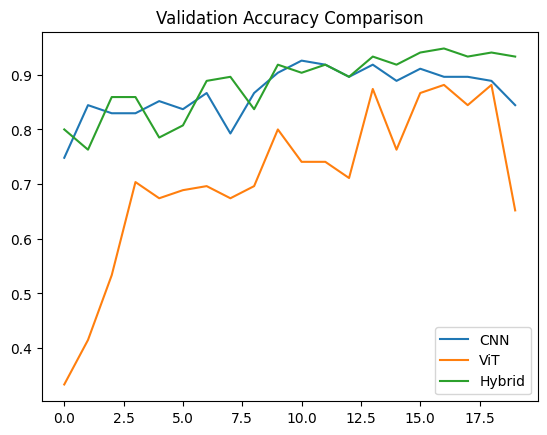

In [ ]:
plt.plot(history_cnn.history['val_accuracy'], label="CNN")
plt.plot(history_vit.history['val_accuracy'], label="ViT")
plt.plot(history_hybrid.history['val_accuracy'], label="Hybrid")
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Select Model:
1 - CNN (EfficientNet)
2 - Transformer (Custom ViT)
3 - Hybrid (CNN + Transformer)
Enter model number (1/2/3): 3

Loading model from: /content/drive/MyDrive/hybrid_model.keras
Model loaded successfully!

Upload a leaf image...


Saving IMG_20250929_101744_aug_0043.jpg to IMG_20250929_101744_aug_0043 (2).jpg


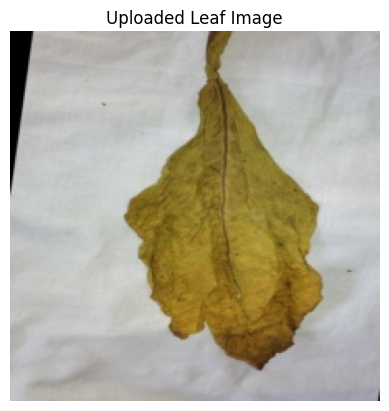

Pixel Range: 0.0 to 222.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

PREDICTION RESULT
Predicted Grade: C
Confidence: 99.94%

Class Probabilities:
A: 0.00%
B: 0.06%
C: 99.94%


In [ ]:
# ==========================================
# FINAL ROBUST TEST SCRIPT (COLAB)
# ==========================================

from google.colab import drive, files
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------
# DEFINE CUSTOM PATCHES LAYER
# ----------------------------

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size
        })
        return config


# ----------------------------
# CONFIG
# ----------------------------

IMG_SIZE = 224
CLASS_NAMES = ['A', 'B', 'C']

MODEL_PATHS = {
    "1": "/content/drive/MyDrive/cnn_model.keras",
    "2": "/content/drive/MyDrive/vit_model.keras",
    "3": "/content/drive/MyDrive/hybrid_model.keras"
}

# ----------------------------
# MOUNT DRIVE
# ----------------------------

drive.mount('/content/drive')

# ----------------------------
# SELECT MODEL
# ----------------------------

print("\nSelect Model:")
print("1 - CNN (EfficientNet)")
print("2 - Transformer (Custom ViT)")
print("3 - Hybrid (CNN + Transformer)")

choice = input("Enter model number (1/2/3): ")

if choice not in MODEL_PATHS:
    print("Invalid choice. Defaulting to Hybrid.")
    choice = "3"

model_path = MODEL_PATHS[choice]

print(f"\nLoading model from: {model_path}")

model = tf.keras.models.load_model(
    model_path,
    custom_objects={"Patches": Patches}
)

print("Model loaded successfully!\n")

# ----------------------------
# UPLOAD IMAGE
# ----------------------------

print("Upload a leaf image...")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Leaf Image")
plt.show()

# ----------------------------
# PREPROCESSING
# ----------------------------

img = image.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img).astype("float32")

# IMPORTANT:
# CNN was trained on 0-255 range
# ViT & Hybrid internally rescale

if choice == "1":  # CNN
    input_data = img_array
else:  # ViT & Hybrid
    input_data = img_array  # DO NOT divide (already handled in model)

input_data = np.expand_dims(input_data, axis=0)

print("Pixel Range:", np.min(input_data), "to", np.max(input_data))

# ----------------------------
# PREDICTION
# ----------------------------

predictions = model.predict(input_data)
predicted_index = np.argmax(predictions)
predicted_class = CLASS_NAMES[predicted_index]
confidence = float(np.max(predictions)) * 100

print("\n==============================")
print("PREDICTION RESULT")
print("==============================")
print(f"Predicted Grade: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")
print("\nClass Probabilities:")

for i, cls in enumerate(CLASS_NAMES):
    print(f"{cls}: {predictions[0][i]*100:.2f}%")